<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px" />

# Lab: Titanic EDA

---
For this lab, we're going to take a look at the Titanic manifest. We'll be exploring this data to see what we can learn regarding the survival rates of different groups of people.

## Step 1: Reading the data

1. Read the titanic data (in the form of the `train.csv` in this repo using the appropriate Pandas method).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train.csv')

### Data Dictionary

| Variable | Description | Details |
|----------|-------------|---------|
| survival | Survival | 0 = No; 1 = Yes |
| pclass | Passenger Class | 1 = 1st; 2 = 2nd; 3 = 3rd |
| name | First and Last Name | |
| sex | Sex | |
| age | Age | |
| sibsp | Number of Siblings/Spouses Aboard | |
| parch | Number of Parents/Children Aboard | |
| ticket | Ticket Number | |
| fare | Passenger Fare | |
| cabin | Cabin | |
| embarked | Port of Embarkation | C = Cherbourg; Q = Queenstown; S = Southampton |

## Step 2: Cleaning the data
####  1. Create a bar chart showing how many missing values are in each column

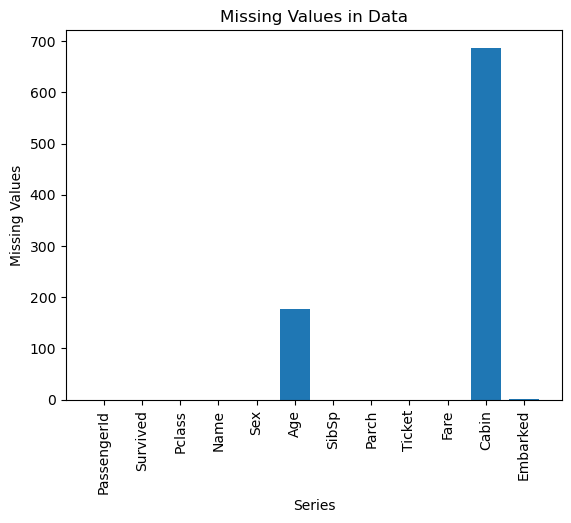

In [6]:
train_1 = train.isnull().sum()

plt.bar(train_1.index.tolist(),train_1.values.tolist())
plt.xlabel('Series')
plt.xticks(rotation=90)
plt.ylabel('Missing Values')
plt.title('Missing Values in Data')
plt.show()

####  2. Which column has the most `NaN` values? How many cells in that column are empty?


In [8]:
train_1.sort_values(ascending = False).head(1)      # Answer: 'Cabin' has the most NaN values, which is 687.

Cabin    687
dtype: int64

In [9]:
(train['Cabin'].str.strip() == '').sum()            # Answer: No empty cells

0

####  3. Delete all rows where `Embarked` is empty

In [11]:
train[train['Embarked'].isnull()]                   # Check the rows that 'Embarked' is NaN

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [12]:
train = train.dropna(subset=['Embarked'])           # Drop all rows that 'Embarked' is NaN

In [13]:
train['Embarked'].isnull().sum()                    # Recheck

0

#### 4. Fill all empty cabins with **¯\\_(ツ)_/¯**

Note: `NaN`, empty, and missing are synonymous.

In [15]:
# Already checked that 'Cabin' has no empty but NaN
# Thus, fillna will work, but the warning Occurs

# train['Cabin'] = train['Cabin'].fillna('¯\\_(ツ)_/¯') 
# A value is trying to be set on a copy of a slice from a DataFrame.
# Try using .loc[row_indexer,col_indexer] = value instead

train.loc[train['Cabin'].isna(), 'Cabin'] = '¯\\_(ツ)_/¯'

In [95]:
print(train['Cabin'].isnull().sum())                 # Recheck NaN
print((train['Cabin'].str.strip() == '').sum())      # Recheck empty

0
0


## Step 3: Feature extraction

#### 1.  There are two columns that pertain to how many family members are on the boat for a given person. Create a new column called `FamilyCount` which will be the sum of those two columns.

In [105]:
# SibSp	Number of Siblings/Spouses Aboard	
# Parch	Number of Parents/Children Aboard

train['FamilyCount'] = train['SibSp'] + train['Parch']

train.head()                                                 # Check

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilyCount
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,¯\_(ツ)_/¯,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,¯\_(ツ)_/¯,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,¯\_(ツ)_/¯,S,0


#### 2. Reverends have a special title in their name. Create a column called `IsReverend`: 1 if they're a preacher, 0 if they're not.


In [143]:
# Reverends has 'Rev.' in their names
# Use apply

train['IsReverend'] = train['Name'].apply(lambda x: 1 if 'Rev.' in x else 0)

In [149]:
train[train['Name'].str.contains('Rev.', na=False)].head(1)      # Check Rev.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilyCount,IsReverend
149,150,0,2,"Byles, Rev. Thomas Roussel Davids",male,42.0,0,0,244310,13.0,¯\_(ツ)_/¯,S,0,1


In [153]:
train[~train['Name'].str.contains('Rev.', na=False)].head(1)      # Check not Rev.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilyCount,IsReverend
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,¯\_(ツ)_/¯,S,1,0


#### 3. In order to feed our training data into a classification algorithm, we need to convert our categories into 1's and 0's using `pd.get_dummies`.

  - Familiarize yourself with the [**`pd.get_dummies` documentation**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)
  - Create 3 columns: `Embarked_C`, `Embarked_Q` and `Embarked_S`. These columns will have 1's and 0's that correspond to the `C`, `Q` and `S` values in the `Embarked` column
  - Do the same thing for `Sex`
  - BONUS (required): Extract the title from everyone's name and create dummy columns

In [199]:
embarked_dummies = pd.get_dummies(train['Embarked'], prefix = 'Embarked')

In [205]:
embarked_dummies.sum()

Embarked_C    168
Embarked_Q     77
Embarked_S    644
dtype: int64

In [207]:
sex_dummies = pd.get_dummies(train['Sex'], prefix = 'Sex')

In [209]:
sex_dummies.sum()

Sex_female    312
Sex_male      577
dtype: int64

In [211]:
# From invesigation, 'Name' is in form 'Lastname, title. Name'

# The following codes extract title from 'Name'
# train['Name'].str.extract(r',\s*([A-Za-z]+)\.') 

# But there are many title other than Mr., Ms., Miss., something royal, french, belgium
# Thus, we omit to do title_dummies

## Step 4: Exploratory analysis

_[`df.groupby()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) may be very useful._

#### 1. What was the survival rate overall?


In [263]:
train[['Survived']].mean().mul(100).round(2)          # Overall Survival Rate can be find by average of Survived

Survived    38.25
dtype: float64

#### 2. Which gender fared the worst? What was their survival rate?

In [279]:
train.groupby('Sex').agg(
    Fare = ('Fare', lambda x: round(x.mean(), 2)),
    Survival_Rate = ('Survived', lambda x: round(x.mean() * 100, 2))
)

# Female has higher fares and survival rates

,Fare,Survival_Rate
Sex,,
female,44.25,74.04
male,25.52,18.89


#### 3. What was the survival rate for each `Pclass`?

In [265]:
train.groupby('Pclass')[['Survived']].mean().mul(100).round(2)

,Survived
Pclass,
1,62.62
2,47.28
3,24.24


#### 4. Did any reverends survive? How many?`

In [283]:
train.groupby('IsReverend').agg(
    Boarding = ('Survived', 'count'),
    Survived = ('Survived', 'sum'),
    Survival_Rate = ('Survived', lambda x: round(x.mean() * 100, 2))
)

# No, they did not make it

,Boarding,Survived,Survival_Rate
IsReverend,,,
0,883,340,38.51
1,6,0,0.00


#### 5. What is the survival rate for cabins marked **¯\\_(ツ)_/¯**

In [366]:
train.groupby('Cabin').agg(
    Boarding=('Survived', 'count'),
    Survived=('Survived', 'sum'),
    Survival_Rate=('Survived', lambda x: round(x.mean() * 100, 2))
).query(r"Cabin == '¯\\_(ツ)_/¯'")

# use 'r' and '\' to escape characters

,Boarding,Survived,Survival_Rate
Cabin,,,
¯\_(ツ)_/¯,687,206,29.99


#### 6. What is the survival rate for people whose `Age` is empty?

In [378]:
train[train['Age'].isnull()].agg(
    Boarding=('Survived', 'count'),
    Survived=('Survived', 'sum'),
    Survival_Rate=('Survived', lambda x: round(x.mean() * 100, 2))
)

,Survived
Boarding,177.00
Survived,52.00
Survival_Rate,29.38


####  7. What is the survival rate for each port of embarkation?

In [380]:
train.groupby('Embarked').agg(
    Boarding=('Survived', 'count'),
    Survived=('Survived', 'sum'),
    Survival_Rate=('Survived', lambda x: round(x.mean() * 100, 2))
)

,Boarding,Survived,Survival_Rate
Embarked,,,
C,168,93,55.36
Q,77,30,38.96
S,644,217,33.70


#### 8. What is the survival rate for children (under 12) in each `Pclass`?

In [382]:
train[train['Age'] <= 12].groupby('Pclass').agg(
    Boarding=('Survived', 'count'),
    Survived=('Survived', 'sum'),
    Survival_Rate=('Survived', lambda x: round(x.mean() * 100, 2))
)

,Boarding,Survived,Survival_Rate
Pclass,,,
1,4,3,75.00
2,17,17,100.00
3,48,20,41.67


####  9. Did the captain of the ship survive? Is he on the list?

In [396]:
# Add Title
train['Title'] = train['Name'].str.extract(r',\s*([A-Za-z]+)\.')

In [404]:
train['Title'].unique()      # He is on the list, the title is Capt.

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', nan, 'Jonkheer'],
      dtype=object)

In [406]:
train[train['Title'] == 'Capt'].groupby('Title').agg(
    Boarding=('Survived', 'count'),
    Survived=('Survived', 'sum'),
    Survival_Rate=('Survived', lambda x: round(x.mean() * 100, 2))
)

# He did not make it

,Boarding,Survived,Survival_Rate
Title,,,
Capt,1,0,0.0


#### 10. Of all the people that died, who had the most expensive ticket? How much did it cost?

In [414]:
train[train['Survived'] == 0].sort_values('Fare',ascending = False).head(1)  

# Fortune, Mr. Charles Alexander whose ticket cost 263.0

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilyCount,IsReverend,Title
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0,C23 C25 C27,S,5,0,Mr


#### 11. Does having family on the boat help or hurt your chances of survival?

In [418]:
train.groupby('FamilyCount').agg(
    Boarding=('Survived', 'count'),
    Survived=('Survived', 'sum'),
    Survival_Rate=('Survived', lambda x: round(x.mean() * 100, 2))
)

# The people whose FamilyCount around 1 to 3 tend to have more survival rates.

,Boarding,Survived,Survival_Rate
FamilyCount,,,
0,535,161,30.09
1,161,89,55.28
2,102,59,57.84
3,29,21,72.41
4,15,3,20.00
5,22,3,13.64
6,12,4,33.33
7,6,0,0.00
10,7,0,0.00


## Step 5: Plotting
Using Matplotlib and Seaborn, create multiple charts showing the survival rates of different groups of people. It's fine if a handful of charts are basic (Gender, Age, etc), but what we're really looking for is something beneath the surface.


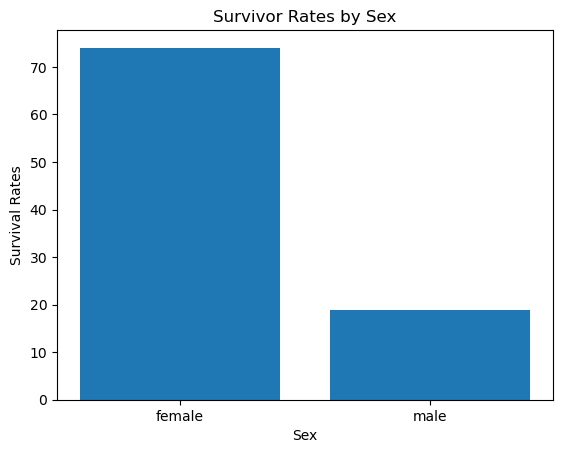

In [444]:
# Survivor Rates by Sex

survivor_counts = train.groupby('Sex')['Survived'].mean().mul(100).round(2)

plt.bar(survivor_counts.index, survivor_counts.values)


plt.xlabel('Sex')
plt.ylabel('Survival Rates')
plt.title('Survivor Rates by Sex')
plt.show()

# Female has more survival rates

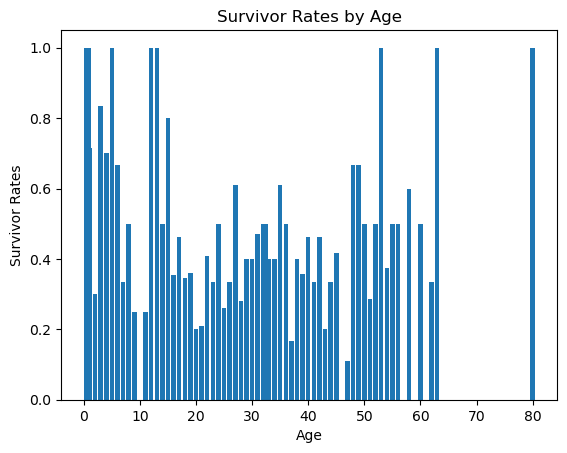

In [446]:
# Survivor Rates by Age

survivor_counts = train.groupby('Age')['Survived'].mean()

plt.bar(survivor_counts.index, survivor_counts.values)


plt.xlabel('Age')
plt.ylabel('Survivor Rates')
plt.title('Survivor Rates by Age')
plt.show()

# The young and the old have more survival rates

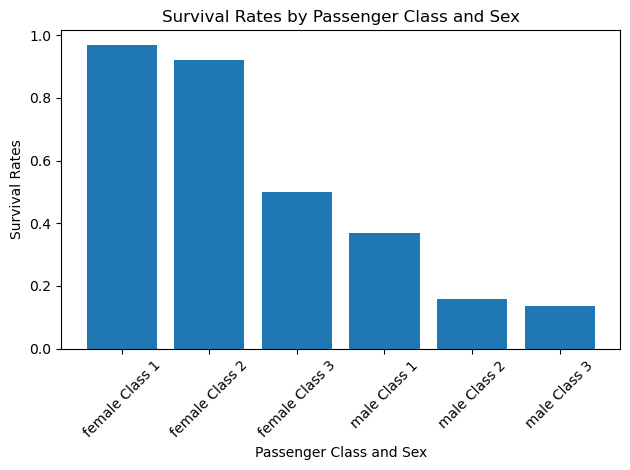

In [460]:
# Survival Rates by Sex and Class

survivor_counts = train.groupby(['Sex', 'Pclass'])['Survived'].mean()

# Reset the index to convert the Series to a DataFrame for easier plotting
survivor_counts = survivor_counts.reset_index()

# Create a new column that combines Pclass and Sex for better labeling
survivor_counts['Sex_Class'] = survivor_counts['Sex'].astype(str) + ' Class ' + survivor_counts['Pclass'].astype(str)

# Create the bar plot
plt.bar(survivor_counts['Sex_Class'], survivor_counts['Survived'])

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Passenger Class and Sex')
plt.ylabel('Survival Rates')
plt.title('Survival Rates by Passenger Class and Sex')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()


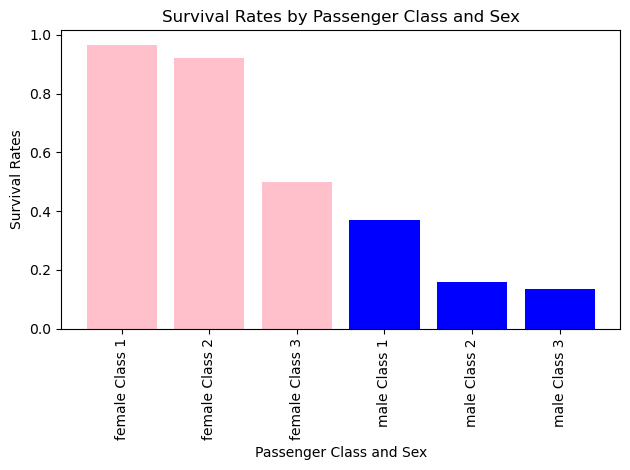

In [486]:
# Calculate survival rates by Sex and Pclass
survivor_counts = train.groupby(['Sex', 'Pclass'])['Survived'].mean()

# Reset the index to convert the Series to a DataFrame for easier plotting
survivor_counts = survivor_counts.reset_index()

# Create a new column labeling
survivor_counts['Sex_Class'] = survivor_counts['Sex'].astype(str) + ' Class ' + survivor_counts['Pclass'].astype(str)

# Define colors based on the column
colors = ['blue' if sex == 'male' else 'pink' for sex in survivor_counts['Sex']]

# Create the bar plot with color
plt.bar(survivor_counts['Sex_Class'], survivor_counts['Survived'], color=colors)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

# Add labels and title
plt.xlabel('Passenger Class and Sex')
plt.ylabel('Survival Rates')
plt.title('Survival Rates by Passenger Class and Sex')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels
plt.show()

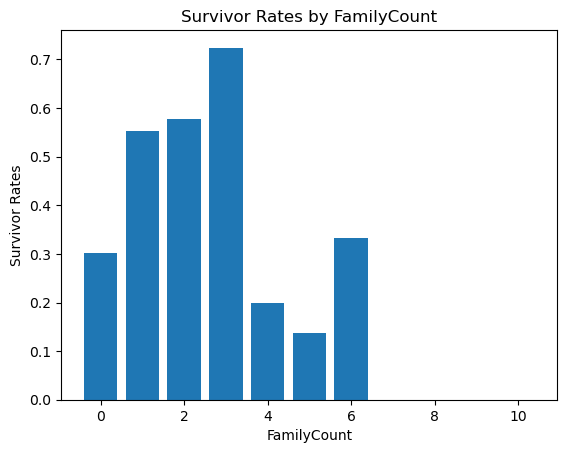

In [488]:
# Survivor Rates by FamilyCount

survivor_counts = train.groupby('FamilyCount')['Survived'].mean()

plt.bar(survivor_counts.index, survivor_counts.values)


plt.xlabel('FamilyCount')
plt.ylabel('Survivor Rates')
plt.title('Survivor Rates by FamilyCount')
plt.show()

# Family tends to survive

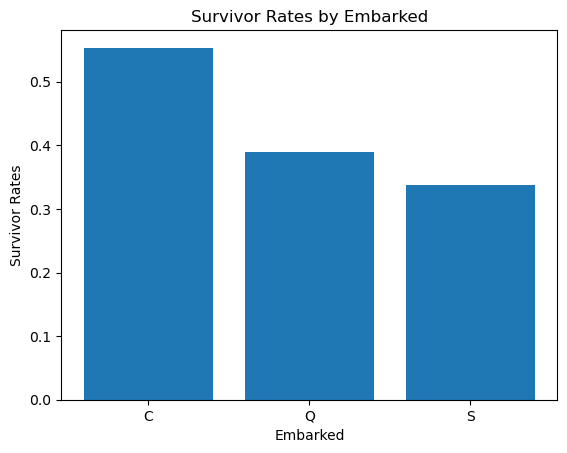

In [492]:
# Survivor Rates by Embarked

survivor_counts = train.groupby('Embarked')['Survived'].mean()

plt.bar(survivor_counts.index, survivor_counts.values)


plt.xlabel('Embarked')
plt.ylabel('Survivor Rates')
plt.title('Survivor Rates by Embarked')
plt.show()

# Embarked C tends to survive